# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [1]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions

In [2]:

from jaxns.special_priors import Bernoulli
from jaxns import Prior, Model

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p, name='predicates')
    p_B = yield Prior(tfpd.Uniform(0.6, 0.9), name='p_B')
    return predicates, p_B


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & P(a) = 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    log_prop = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9)) + jnp.where(b, jnp.log(p_B), jnp.log(1. - p_B))

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2023-01-02 14:48:24,360]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-01-02 14:48:24,361]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:48:24,362]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-01-02 14:48:24,363]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-01-02 14:48:24,364]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-01-02 14:48:24,364]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO[2023-01-02 14:48:25,095]: Sanity check...
INFO[2023-01-02 14:48:25,577]: Sanity check p

In [3]:
from jaxns import ExactNestedSampler, TerminationCondition

# Run the nested sampling
ns = ExactNestedSampler(model=model, num_live_points=200, max_samples=1e4)

term_reason, state = ns(random.PRNGKey(3452345), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = ns.to_results(state, termination_reason=term_reason)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 18643
# samples: 1261
# slices: 9000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 14.8
# likelihood evals / slice: 1.9
--------
logZ=-1.067 +- 0.045
H=1.6
ESS=315
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.43 +- 0.28 | 0.06 / 0.39 / 0.84 | 0.01 | 0.49
p[1]: 0.57 +- 0.28 | 0.18 / 0.57 / 0.94 | 0.92 | 0.87
p[2]: 0.52 +- 0.3 | 0.09 / 0.53 / 0.93 | 0.97 | 0.51
--------
p_B: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p_B: 0.754 +- 0.086 | 0.645 / 0.751 / 0.876 | 0.882 | 0.9
--------
predicates[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
predicates[0]: 0.3 +- 0.46 | 0.0 / 0.0 / 1.0 | 0.0 | 1.0
predicates[1]: 0.74 +- 0.44 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
predicates[2]: 0.57 +- 0.5 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
--------


WARNING[2023-01-02 14:48:36,653]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


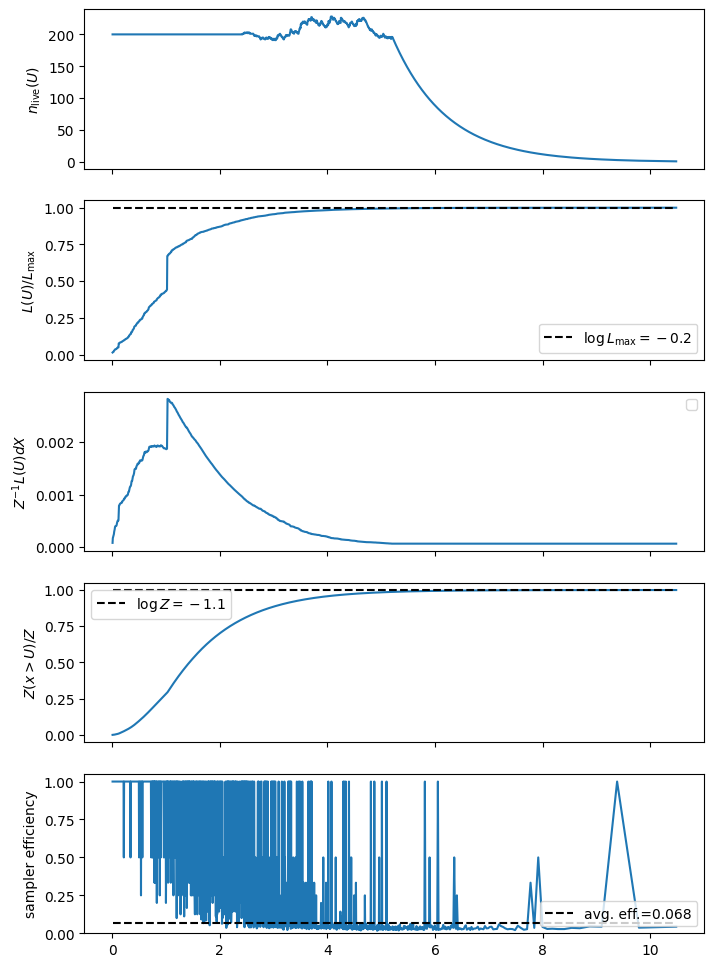

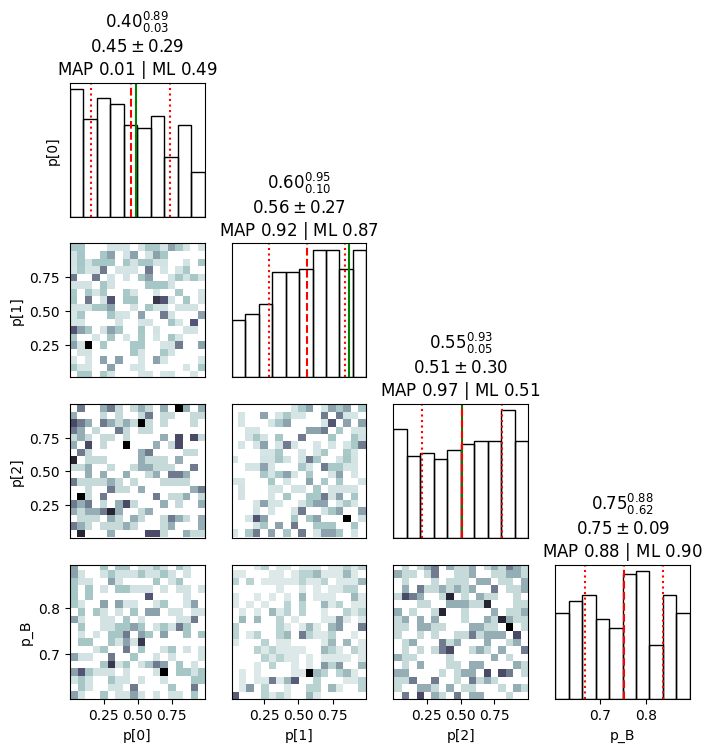

In [4]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results, vars=['p', 'p_B'])